In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error
from datetime import datetime
import seaborn as sns
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score

# !pip install pytorch-tabnet
from pytorch_tabnet.tab_model import TabNetRegressor
import os
from sklearn.preprocessing import LabelEncoder
import sklearn.preprocessing as skl

np.random.seed(0)

In [ ]:
data = pd.read_csv('Walmart_Store_sales2.csv')
# data = pd.read_csv('1.csv')
data.Temperature=data.Temperature.mask(data.Temperature.lt(0),0)

In [ ]:
data.head()

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,1554806.68,0,46.50,2.625,211.350143,8.106


In [ ]:
dataForDates = pd.read_csv('Walmart_Store_sales.csv')
dataForDates['Date'] = pd.to_datetime(dataForDates['Date'])
dataForDates.set_index('Date', inplace= True)
# data =data.resample('D').mean()

<ipython-input-149-584ffe002670>:2: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  dataForDates['Date'] = pd.to_datetime(dataForDates['Date'])


,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
Date,,,,,,,
2010-05-02,1,1643690.90,0,42.31,2.572,211.096358,8.106
2010-12-02,1,1641957.44,1,38.51,2.548,211.242170,8.106
2010-02-19,1,1611968.17,0,39.93,2.514,211.289143,8.106
2010-02-26,1,1409727.59,0,46.63,2.561,211.319643,8.106
2010-05-03,1,1554806.68,0,46.50,2.625,211.350143,8.106


In [ ]:
data.shape

(6435, 7)

In [ ]:
data.drop_duplicates()
data.shape

(6435, 7)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         6435 non-null   int64  
 1   Weekly_Sales  6435 non-null   float64
 2   Holiday_Flag  6435 non-null   int64  
 3   Temperature   6435 non-null   float64
 4   Fuel_Price    6435 non-null   float64
 5   CPI           6435 non-null   float64
 6   Unemployment  6435 non-null   float64
dtypes: float64(5), int64(2)
memory usage: 352.0 KB


In [ ]:
from scipy.interpolate import interp1d

In [ ]:
data['Weekly_Sales'] = data['Weekly_Sales'].interpolate()# заполнение пустотых строк нулем

In [ ]:
data.head()

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,1554806.68,0,46.50,2.625,211.350143,8.106


In [ ]:
train = data

In [ ]:
target = 'Weekly_Sales'
if "Set" not in train.columns:
    train["Set"] = np.random.choice(["train", "valid", "test"], p =[.8, .1, .1], size=(train.shape[0],))

train_indices = train[train.Set=="train"].index
valid_indices = train[train.Set=="valid"].index
test_indices = train[train.Set=="test"].index
dataset_name = 'Table'

In [ ]:
categorical_columns = []
categorical_dims =  {}
for col in train.columns[train.dtypes == object]:
    print(col, train[col].nunique())
    l_enc = LabelEncoder()
    train[col] = train[col].fillna("VV_likely")
    train[col] = l_enc.fit_transform(train[col].values)
    categorical_columns.append(col)
    categorical_dims[col] = len(l_enc.classes_)

for col in train.columns[train.dtypes == 'float64']:
    train.fillna(train.loc[train_indices, col].mean(), inplace=True)

Set 3


In [ ]:
unused_feat = ['Set']

features = [ col for col in train.columns if col not in unused_feat+[target]] 

# Список типа int индексов категориальных признаков
cat_idxs = [ i for i, f in enumerate(features) if f in categorical_columns]

# Список типа int, количество уникальных значений для категориального признака, новые модальности не могут быть предсказаны
cat_dims = [ categorical_dims[f] for i, f in enumerate(features) if f in categorical_columns]

# Список типа int размеров вложений для каждой категориальной функции (по умолчанию =1)
# Определение размеров: здесь просто случайный набор
cat_emb_dim = [5, 4, 3, 6, 2, 2, 9, 10]

In [ ]:
clf = TabNetRegressor(cat_dims=cat_dims, cat_emb_dim=cat_emb_dim, cat_idxs=cat_idxs)

train.head()

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Set
0,1,1643690.90,0,42.31,2.572,211.096358,8.106,1
1,1,1641957.44,1,38.51,2.548,211.242170,8.106,1
2,1,1611968.17,0,39.93,2.514,211.289143,8.106,1
3,1,1409727.59,0,46.63,2.561,211.319643,8.106,1
4,1,1554806.68,0,46.50,2.625,211.350143,8.106,1


In [ ]:
# np.массив особенностей обучения
X_train = train[features].values[train_indices]
# y_train - np.массив учебных целей
y_train = train[target].values[train_indices].reshape(-1, 1)

X_valid = train[features].values[valid_indices]
y_valid = train[target].values[valid_indices].reshape(-1, 1)

X_test = train[features].values[test_indices]
y_test = train[target].values[test_indices].reshape(-1, 1)

### Алгоритмы глубокого обучения, не прошедшие проверку

Мною был рассмотрен ряд архитектур глубокого обучения, подходящих по своим параметрам, а также рекомендованных для обучения табличных данных в ранее рассмотренных статьях. Многие из них не подошли по различным причинам для написания сервиса прогнозирования продаж

Модель, которая использует отсев методом Монте-Карло, чтобы обеспечить форму ансамбля для окончательных прогнозов модели<br>
Может давать хорошие результаты (https://tinyurl.com/yc54us3k) <br>
Точность обучения слишком низкая <br>
Реализация - https://www.kaggle.com/code/benfraser/eda-and-dnn-regression-models 

In [ ]:
import keras
from keras.layers import Dense, Embedding, Flatten, LSTM, GRU, \
        SpatialDropout1D, Bidirectional, Conv1D, MaxPooling1D, BatchNormalization
from keras import layers
from keras import models
import tensorflow as tf

class MonteCarloDropout(layers.Dropout):
    def call(self, inputs):
        return super().call(inputs, training=True)
        
def pred_mc_dropout(model, test_inputs, n_samples=50):
    """ Make a large number of predictions (equal to n_samples) using the 
        passed model and input features """
    pred_probs = [model.predict(test_inputs) for samples in range(n_samples)]
    return np.mean(pred_probs, axis=0)

def ann_model(monte_carlo_dropout=False, dropout_val=0.45, lr=2e-3, 
              input_feat_dim=X_train.shape[1]):
    """ Create a Deep NN for regression that supports monte carlo dropout
        and uses Batch Norm """
    model = models.Sequential()
    
    model.add(layers.Dense(200, activation='elu', input_shape=(input_feat_dim,), 
                           kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    if monte_carlo_dropout:
        model.add(MonteCarloDropout(dropout_val))
    else:
        model.add(layers.Dropout(dropout_val))
    model.add(layers.Dense(100, activation='elu', kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    if monte_carlo_dropout:
        model.add(MonteCarloDropout(dropout_val))
    else:
        model.add(layers.Dropout(dropout_val))
    model.add(layers.Dense(50, activation='elu', kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    if monte_carlo_dropout:
        model.add(MonteCarloDropout(dropout_val))
    else:
        model.add(layers.Dropout(dropout_val))
        
    # regression output layer - no activation
    model.add(layers.Dense(1))
        
    model.compile(optimizer=keras.optimizers.Nadam(lr=lr), 
                  loss='mse', metrics=['mse'])
    
    return model
model_1 = ann_model(monte_carlo_dropout=True, lr=1e-3)

def schedule_lr_rate(epoch, lr):
    """ Use initial learning rate for 20 epochs and then
        decrease it exponentially """
    if epoch < 20:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

early_stopper = keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True)

# list of callbacks to use
trg_callbacks = [early_stopper]

model_1.fit(X_train, y_train, epochs=200, 
                      batch_size=256, validation_data=(X_valid, y_valid), 
                      callbacks=trg_callbacks)

Montepreds = model_1.predict(X_test)

Глубокая самонормализующаяся сеть SELU с AlphaDropout Монте-Карло <br>
Может давать хорошие результаты (https://tinyurl.com/yc54us3k) <br>
Точность обучения слишком низкая <br>
Реализация - https://www.kaggle.com/code/benfraser/eda-and-dnn-regression-models 

In [ ]:
class MCAlphaDropout(keras.layers.AlphaDropout):
    """ Custom Monte Carlo Alpha Dropout layer """
    def call(self, inputs):
        return super().call(inputs, training=True)
    
    
def pred_mc_dropout(model, test_inputs, n_samples=50):
    """ Make a large number of predictions (equal to n_samples) using the 
        passed model and input features """
    pred_probs = [model.predict(test_inputs) for samples in range(n_samples)]
    return np.mean(pred_probs, axis=0)

def dnn_selu(layers=20, neurons=100, dropout_rate=0.4):
    """ Deeply stacked SELU network with self-normalisation and Monte
        Carlo AlphaDropout 
    """
    model = keras.models.Sequential()
    
    # stack SELU layers with alpha dropout
    for layer in range(layers):
        model.add(keras.layers.Dense(neurons, activation='selu',
                               kernel_initializer='lecun_normal'))
        
        # add alpha dropout to our last layers
        if layer >= (layers - 2):
            model.add(MCAlphaDropout(rate=dropout_rate))
    
    # final regression layer
    model.add(keras.layers.Dense(1))
    
    model.compile(loss='mse', 
                  optimizer=keras.optimizers.Nadam(lr=1e-4), 
                  metrics=['mse'])
    return model

model_2 = dnn_selu()

early_stopper = keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True)

checkpoint_cb = keras.callbacks.ModelCheckpoint("dnn_selu_dropout.h5", save_best_only=True)

trg_callbacks = [early_stopper, checkpoint_cb]

model_2.fit(X_train, y_train, epochs=100, 
                     batch_size=256, validation_data=(X_valid, y_valid), 
                     callbacks=trg_callbacks)
Montepreds = model_2.predict(X_test)

Метод регрессии на глубоких нейронных сетях - точность обучения слишком низкая. Автор показывает хорошие результаты на представленной выборке, однако, на данных продаж точность модели сильно снизилась <br>
https://www.kaggle.com/code/shubhikant/dnn-regression 

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
# !pip install tensorflow==2.12.0
import tensorflow as tf

from tensorflow import keras
from tensorflow.python.keras import layers
from tensorflow.keras.layers import experimental
from tensorflow.keras.layers.experimental import preprocessing

from tensorflow.python.keras.callbacks import TensorBoard
print(tf.__version__)

model = keras.Sequential([
                          layers.Dense(16, activation='relu'), 
                          layers.Dense(16, activation='relu'),
                          layers.Dense(3)])
model.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.Adam(0.001))

2.12.0


In [ ]:
history = model.fit(X_train, 
                    np.asarray(y_train).astype('float32'),
                    validation_split=0.2, verbose=0, epochs=100)

По моим исследованиям, многослойный перцептрон Румельхарта (MLP) очень плохо справился с задачей регрессии, к тому же требует изменения зависимого поля в зависимости от размера/структуры данных, что делает его сложноприменимым в задачах прогнозирования на любых данных <br>
Является одной из лучших архитектур нейронных сетей, мог показать хорошие результаты (https://www.marktechpost.com/2022/09/23/top-neural-network-architectures-for-machine-learning-researchers/) <br>
Реализация: https://github.com/christianversloot/machine-learning-articles/blob/main/creating-an-mlp-for-regression-with-keras.md 

In [ ]:
from tensorflow import keras
from keras.layers import Dense
from keras.models import Sequential
import numpy as np

input_shape = (7,)
# Create the model
model = Sequential()
model.add(Dense(16, input_shape=input_shape, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='linear'))

# Configure the model and start training
model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_squared_error'])
model.fit(X_train, y_train, epochs=3, batch_size=1, verbose=1, validation_split=0.2)

In [ ]:
MLPpreds = model.predict(X_test)

In [ ]:
plt.figure(figsize=(20,9))
plt.plot(y_test , 'blue', linewidth=5)
plt.plot(MLPpreds,'r' , linewidth=4)
plt.legend(('Test','Predicted'))
plt.title("Temperature Prediction")
plt.show()

In [ ]:
y_true = y_test
score = r2_score(y_true, MLPpreds)
print("Точность модели составляет {}%".format(round(score, 2) *100))

### Другие неподходящие модели, но рекомендуемые в ранее изученных исследованиях нейронных сетей с глубоким обучением
(https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=9998482 ,
https://www.sciencedirect.com/science/article/abs/pii/S1566253521002360)

SAINT: улучшенная нейронная сеть для табличных данных с помощью внимания к ряду и контрастного предварительного обучения. По рузультатам исследования может превосходить классические подходы - XGBoost, CatBoost на больших данных (https://arxiv.org/pdf/2110.01889.pdf). Проблема слишком больших данных для ансамблевого прогнозирования в том, что они будут слишком долго обучаться, поэтому можно использовать другой подход.

NODE - отсутствуют данные по использованию, тяжело использовать, потому что библиотека не импортируется как другие решения, работает медленно, что в сочетании с TabNet плохо скажется на конечном времени обучения.

DNF-net - отсутствует пример использования, сложно подстроить под свою задачу.

TabPFN - исследования показывают хорошие результаты (https://sebastianraschka.com/blog/2022/deep-learning-for-tabular-data.html#language-models-are-realistic-tabular-data-generators-2022-10). Однако, его основная задача заключается в решении небольших задач табличной классификации. В результате моих исследований было выявлено, что он также не работает с тренировочной выборкой больше 1024 элементов. 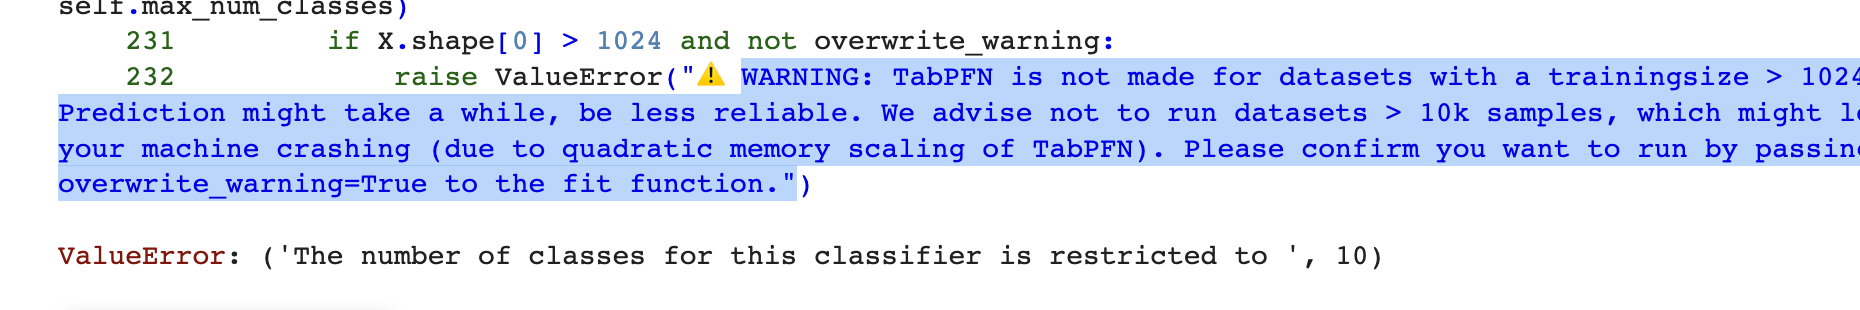

TabTransformer - отсутствует официальная реализация.

### Также была исследована модель авторегрессии, которая используется в гибридном обучении
(https://github.com/huytjuh/Hybrid-Time-Series-Modeling)

ARIMA - создаёт сильную нагрузку на вычислительные ресурсы, медленно обучается
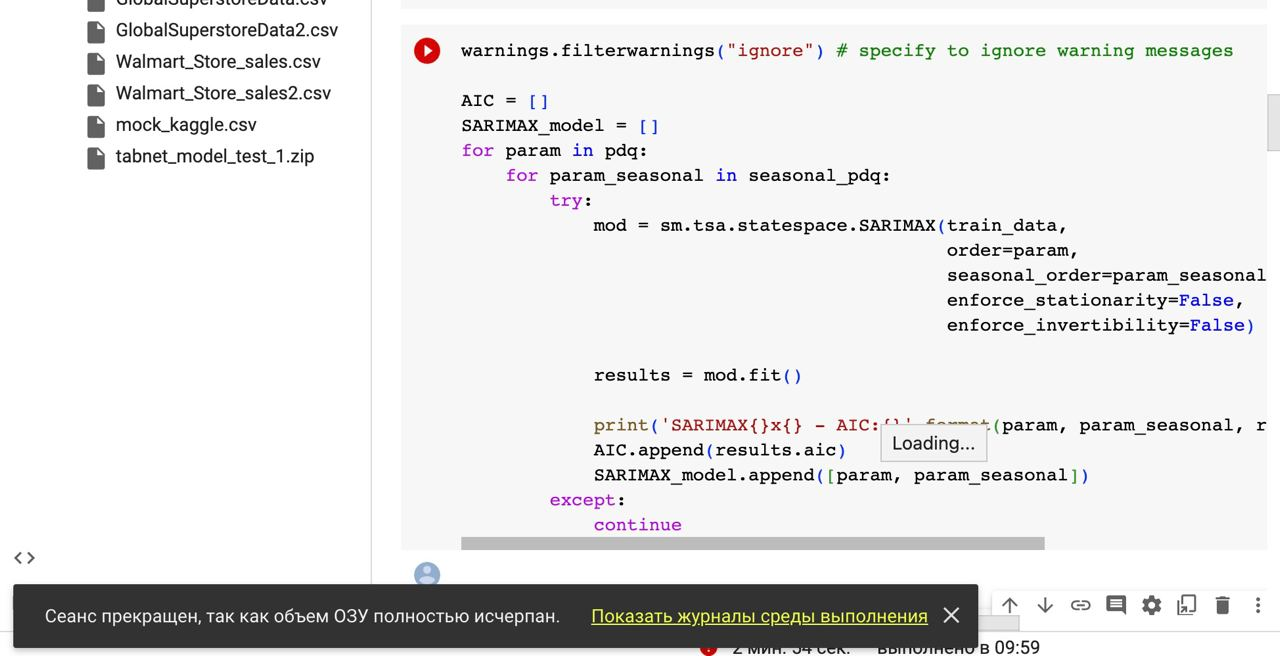